<a href="https://colab.research.google.com/github/ecbme4040/e4040-2022Fall-Project-AHSN-am5964-hsp2122-ska2145/blob/main/stanford_dogs_%D9%90%D9%90Experiments/sd_90_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AHSN Project
#### Done by:
Safeyah Alshemali(ska2145) - Hannah Portes(hsp2122) - Aparna Muraleekrishnan(am5964)

#### Based on Paper: 
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications
[link](https://https://arxiv.org/abs/1704.04861)

#### Authors: 
Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam

Code Libraries

Below is the process of loading the data of Stanford Dogs. This tensorflow dataset has 120 classes, 12000 training samples and 8580 test samples.

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import keras
from keras import datasets, layers, models
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, Activation , DepthwiseConv2D, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D,  GlobalAveragePooling2D, AveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

##Data Processing

In [ ]:
# load the data
dogs, info = tfds.load(name="stanford_dogs", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete06F3S3/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete06F3S3/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


##Data Visualization

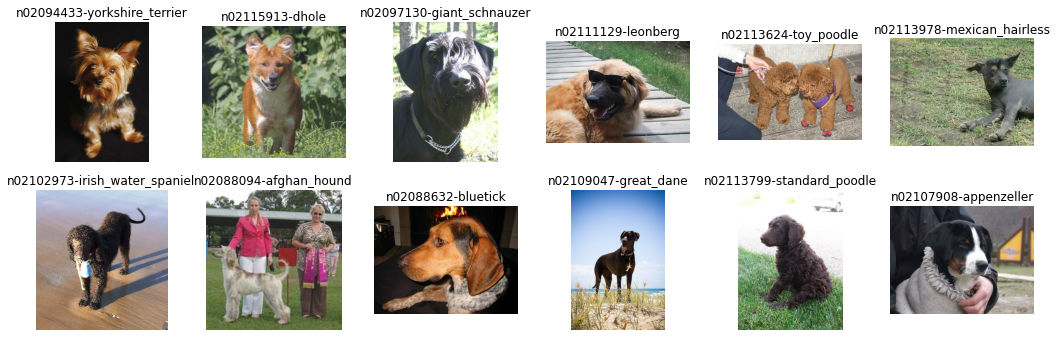

In [ ]:
# define functions to process the data
breeds = 120

training_data = dataset['train']
test_data = dataset['test']


def resize_onehot(img):
    # Image resize
    image = tf.image.convert_image_dtype(img['image'], dtype=tf.float32)
    image = tf.image.resize(image, (128, 128), method='nearest')
    # Onehot encode the labels
    label = tf.one_hot(img['label'], breeds)

    return image, label

def prepare(dataset, batch_size):
    data = dataset.map(resize_onehot)
    data = data.shuffle(buffer_size=1000)
    data = data.batch(batch_size)
    data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return data

In [ ]:
# name the training and test data seperately 
training_data, test_data = dogs['train'], dogs['test']


In [ ]:
train_size = int(0.8 * 12000)
val_size  = int(0.2 * 12000)

train_dataset = training_data.take(train_size)
val_dataset  = training_data.skip(train_size)


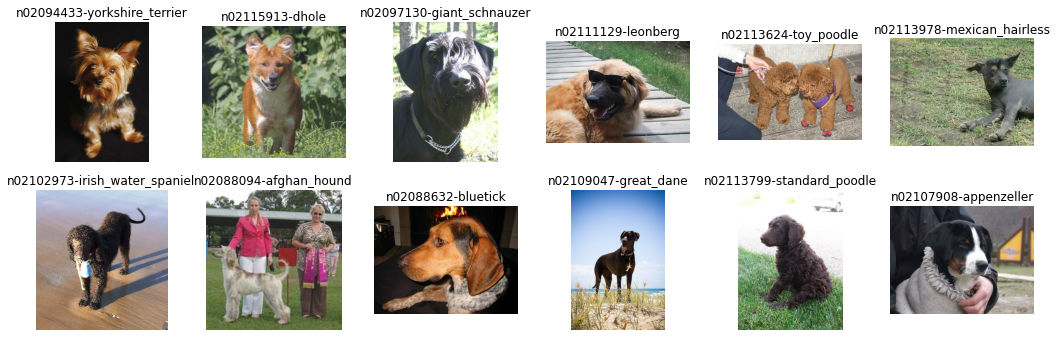

In [ ]:
plt.figure(figsize=(18, 18))

num = 0

for dog in train_dataset.take(12):
    ax = plt.subplot(6, 6, num + 1)
    plt.imshow(dog['image'])
    plt.title(breed_name(dog['label']))
    plt.axis("off")
    num += 1

In [ ]:
# print some basic information 
num_classes = info.features['label'].num_classes

print('Number of classes/dog breeds: ', num_classes)
print('Number of training samples: ', train_dataset.__len__().numpy())
print('Number of val samples: ', val_dataset.__len__().numpy())

Number of classes/dog breeds:  120
Number of training samples:  9600
Number of val samples:  2400


## MobileNet Model

Model Creation

In [ ]:
def create_MobileNet_model(input_shape, no_classes):
    
    print('layer 1 input', input_shape)

    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    print('layer 2 input', x.shape)
    #second layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(64,(1, 1), (1, 1) ,x)

    print('layer 3 input', x.shape)
    #third layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(128,(1, 1), (1, 1) ,x)
    
    
    print('layer 4 input', x.shape)
    #4th layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(128,(1, 1), (1, 1) ,x)

    print('layer 5 input', x.shape)
    #5th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(256,(1, 1), (1, 1) ,x)

    print('layer 6 input', x.shape)
    #6th layer (Conv dw/s1) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(256,(1, 1), (1, 1) ,x)

    print('layer 7 input', x.shape)
    #7th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(512,(1, 1), (1, 1) ,x)

    print('layer 8 stack input', x.shape)
    #8thlayer: 5 * (Conv dw/s1) + (Conv dw /s1)
    for _ in range(5):
      x = DepthWiseConv((3,3), (1,1), x)
      x = PointWiseConv(512,(1, 1), (1, 1) ,x)

    print('layer 9 input', x.shape)
    #9th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (2,2), x)
    x = PointWiseConv(1024,(1, 1), (1, 1) ,x)

    print('layer 10 input', x.shape)
    #10th layer (Conv dw/s2) + (Conv /s1)
    x = DepthWiseConv((3,3), (1,1), x)
    x = PointWiseConv(1024,(1, 1), (1, 1) ,x)

    print('Avg Pooling input', x.shape)
    #11th layer: Avg Pooling (7*7)
    # x = AveragePooling2D(pool_size=(7,7), strides=(1,1))(x)
    x = GlobalAveragePooling2D()(x)
    print('Flatten input', x.shape)
    #print('Flatten layer input', x.shape)
    #Flatten layer / s1? 
    # x = Flatten()(x)

    print('Dense 12 input', x.shape)
    #12th layer : Affine layer
    out = Dense(no_classes,activation='softmax')(x)

    print('out', out.shape)

    model = Model(input, out, name='mobilenet')

    return model    

The Depthwise Separable Convolution layer

In [ ]:
def DepthWiseConv(kernal_size, stride, x):
    result = DepthwiseConv2D(kernal_size, strides=stride , padding='same')(x)
    result = BatchNormalization()(result)
    result = Dropout(0.2)(result)
    result = Activation('relu')(result)
    return result

In [ ]:
def PointWiseConv(filters,kernal_size, stride, x):
    result = Conv2D(filters, kernel_size=kernal_size, strides=stride)(x)
    result = BatchNormalization()(result)
    result = Dropout(0.2)(result)
    result = Activation('relu')(result)
    return result

Fitting and Training the Model

In [ ]:
MobileNet = create_MobileNet_model((124,124,3),120)
MobileNet.summary()


layer 1 input (124, 124, 3)
layer 2 input (None, 62, 62, 32)
layer 3 input (None, 62, 62, 64)
layer 4 input (None, 31, 31, 128)
layer 5 input (None, 31, 31, 128)
layer 6 input (None, 16, 16, 256)
layer 7 input (None, 16, 16, 256)
layer 8 stack input (None, 8, 8, 512)
layer 9 input (None, 8, 8, 512)
layer 10 input (None, 4, 4, 1024)
Avg Pooling input (None, 4, 4, 1024)
Flatten input (None, 1024)
Dense 12 input (None, 1024)
out (None, 120)
Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        864       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
           

In [ ]:
# train_batches = prepare(training_data, batch_size=32)
# test_batches = prepare(test_data, batch_size=32)

In [ ]:
train_batches = prepare(train_dataset, batch_size=32)
test_batches = prepare(val_dataset, batch_size=32)


In [ ]:
MobileNet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1)
callbacks_list = [checkpoint]
          

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
#                                                  save_weights_only=True,
#                                                  verbose=1, monitor='accuracy')

history = MobileNet.fit(train_batches,
                    epochs=90,
                    validation_data=test_batches, callbacks=callbacks_list, shuffle=True)

# MobileNet.load_weights(checkpoint_filepath)


Epoch 1/90
300/300 [==============================] - ETA: 0s - loss: 5.0023 - accuracy: 0.0100
Epoch 1: saving model to weights-improvement-01-0.01.hdf5
300/300 [==============================] - 57s 140ms/step - loss: 5.0023 - accuracy: 0.0100 - val_loss: 5.6495 - val_accuracy: 0.0054
Epoch 2/90
300/300 [==============================] - ETA: 0s - loss: 4.9526 - accuracy: 0.0127
Epoch 2: saving model to weights-improvement-02-0.01.hdf5
300/300 [==============================] - 40s 128ms/step - loss: 4.9526 - accuracy: 0.0127 - val_loss: 6.5255 - val_accuracy: 0.0054
Epoch 3/90
300/300 [==============================] - ETA: 0s - loss: 4.8521 - accuracy: 0.0122
Epoch 3: saving model to weights-improvement-03-0.01.hdf5
300/300 [==============================] - 40s 128ms/step - loss: 4.8521 - accuracy: 0.0122 - val_loss: 5.5956 - val_accuracy: 0.0100
Epoch 4/90
300/300 [==============================] - ETA: 0s - loss: 4.6911 - accuracy: 0.0155
Epoch 4: saving model to weights-improve

Plot the Training and Validation acuuracy and Loss

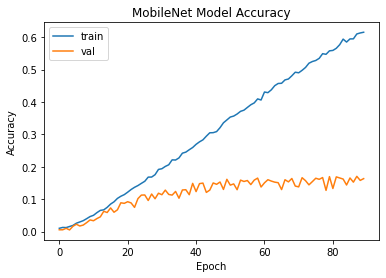

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MobileNet Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

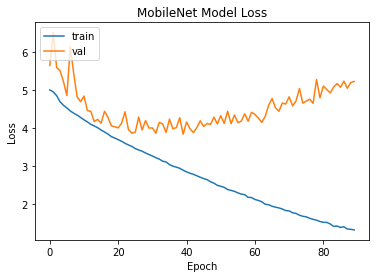

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNet Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_batches = prepare(training_data, batch_size=64)
test_batches = prepare(test_data, batch_size=64)

model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches)

## CNN Model

Model Creation

In [ ]:
def create_CNN_model(input_shape, no_classes):
    
    print('layer 1 input', input_shape)

    #first layer (Conv/s2)
    input = Input(shape= input_shape)
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2) ,padding='same', use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    print('layer 2 input', x.shape)
    #second layer (Conv dw/s1) + (Conv /s1)
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(64,(3,3),(1,1),x)(x)

    print('layer 3 input', x.shape)
    #third layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(128, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(128,(3,3), (2,2),x)(x)  
    
    print('layer 4 input', x.shape)
    #4th layer (Conv dw/s1) + (Conv /s1)
    x = Conv2D(128, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(128,(3,3), (1,1),x)(x)

    print('layer 5 input', x.shape)
    #5th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(256, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(256,(3,3), (2,2),x)(x)

    print('layer 6 input', x.shape)
    #6th layer (Conv dw/s1) + (Conv /s1)
    x = Conv2D(256, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(256,(3,3), (1,1),x)(x)

    print('layer 7 input', x.shape)
    #7th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(512, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(512,(3,3), (2,2),x)(x)

    print('layer 8 stack input', x.shape)
    #8thlayer: 5 * (Conv dw/s1) + (Conv dw /s1)
    for _ in range(5):
      x = Conv2D(512, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      #x = standard_Conv(512,(3,3), (1,1),x)(x)
      
    print('layer 9 input', x.shape)
    #9th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(1024, kernel_size=(3,3), strides=(2,2) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(1024,(3,3), (2,2),x)(x)

    print('layer 10 input', x.shape)
    #10th layer (Conv dw/s2) + (Conv /s1)
    x = Conv2D(1024, kernel_size=(3,3), strides=(1,1) ,padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = standard_Conv(1024,(3,3), (1,1),x)(x)

    print('Avg Pooling input', x.shape)
    #11th layer: Avg Pooling (7*7)
    x = AveragePooling2D(pool_size=(4,4), strides=(1,1))(x)

    print('Flatten input', x.shape)
    #print('Flatten layer input', x.shape)
    #Flatten layer / s1? 
    # x = Flatten()(x)
    x = GlobalAveragePooling2D()(x)

    print('Dense 12 input', x.shape)
    #12th layer : Affine layer
    out = Dense(no_classes,activation='softmax')(x)

    print('out', out.shape)

    model = Model(input, out, name='CNN')

    return model    

In [ ]:
def standard_Conv(filter,kernal_size, stride, x):
  x = Conv2D(filter, kernel_size=kernal_size, strides=stride ,padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Activation('relu')(x)
  return x

Fitting and Training the Model

In [ ]:
CNN_Model = create_CNN_model((124,124,3),120)
CNN_Model.summary()


layer 1 input (124, 124, 3)
layer 2 input (None, 62, 62, 32)
layer 3 input (None, 62, 62, 64)
layer 4 input (None, 31, 31, 128)
layer 5 input (None, 31, 31, 128)
layer 6 input (None, 16, 16, 256)
layer 7 input (None, 16, 16, 256)
layer 8 stack input (None, 8, 8, 512)
layer 9 input (None, 8, 8, 512)
layer 10 input (None, 4, 4, 1024)
Avg Pooling input (None, 4, 4, 1024)
Flatten input (None, 1, 1, 1024)
Dense 12 input (None, 1024)
out (None, 120)
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 124, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        864       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
           

In [ ]:
CNN_Model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train_batches = prepare(train_dataset, batch_size=32)
# test_batches = prepare(val_dataset, batch_size=32)

history_cnn = CNN_Model.fit(train_batches, epochs=90, validation_data=test_batches, verbose=1)



Epoch 1/90
300/300 [==============================] - 52s 145ms/step - loss: 4.9521 - accuracy: 0.0091 - val_loss: 4.9046 - val_accuracy: 0.0100
Epoch 2/90
300/300 [==============================] - 46s 144ms/step - loss: 4.8283 - accuracy: 0.0064 - val_loss: 4.7958 - val_accuracy: 0.0050
Epoch 3/90
300/300 [==============================] - 45s 144ms/step - loss: 4.7748 - accuracy: 0.0121 - val_loss: 4.7878 - val_accuracy: 0.0158
Epoch 4/90
300/300 [==============================] - 45s 144ms/step - loss: 4.6688 - accuracy: 0.0143 - val_loss: 4.6346 - val_accuracy: 0.0150
Epoch 5/90
300/300 [==============================] - 46s 147ms/step - loss: 4.6006 - accuracy: 0.0178 - val_loss: 4.5604 - val_accuracy: 0.0217
Epoch 6/90
300/300 [==============================] - 45s 144ms/step - loss: 4.5593 - accuracy: 0.0189 - val_loss: 4.5428 - val_accuracy: 0.0188
Epoch 7/90
300/300 [==============================] - 45s 144ms/step - loss: 4.5278 - accuracy: 0.0230 - val_loss: 4.5356 - val_ac

Plot the Training and Validation acuuracy and Loss

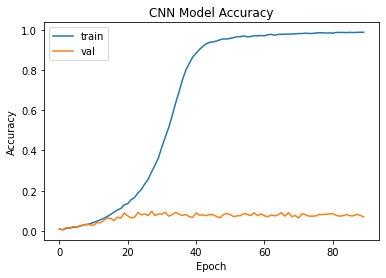

In [ ]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

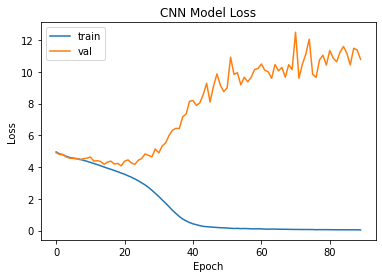

In [ ]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()